In [1]:
import importlib
import ubx_parser
from matplotlib import pyplot as plt
import importer
import math
from pyproj import Proj
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from geopy.distance import great_circle
import utils
from scipy.signal import butter,filtfilt



In [2]:
importlib.reload(importer)
importlib.reload(ubx_parser)
importlib.reload(utils)


filename = 'ubx_records/ground_truth_1.ubx'
ubx_1 = ubx_parser.read_ubx(filename)


filename = 'ubx_records/ground_truth_2.ubx'
ubx_2 = ubx_parser.read_ubx(filename)

Attribute error. Coordinate is ignored.


In [ ]:
importlib.reload(importer)


path = 'simra_records/'

dfs = importer.import_files(path)

mi9_1 = importer.preprocess_basics(dfs[2], True)
a2_1 = importer.preprocess_basics(dfs[0], True)

mi9_2 = importer.preprocess_basics(dfs[1], True)
a2_2 = importer.preprocess_basics(dfs[3], True)

experiments_ = [(ubx_1, [mi9_1, a2_1]), (ubx_2, [mi9_2, a2_2])]


 50%|█████     | 2/4 [00:00<00:00,  4.32it/s]

simra_records/A2_1_jacket 0
simra_records/Mi9_2_jacket 1


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]

simra_records/Mi9_1_jacket 2
simra_records/A2_2_jacket 3


1.0414853908992663 0.5207426954496331


In [4]:
experiments = []
for exp in experiments_:

    ref_date_min = max(exp[1][0].date.min(), exp[1][1].date.min())

    exp[1][0] = exp[1][0][exp[1][0].date >= ref_date_min]
    exp[1][1] = exp[1][1][exp[1][1].date >= ref_date_min]

    ref_date_max = min(exp[1][0].date.max(), exp[1][1].date.max())
    exp[1][0] = exp[1][0][exp[1][0].date <= ref_date_max]
    exp[1][1] = exp[1][1][exp[1][1].date <= ref_date_max]


    comp = pd.merge_asof(exp[1][0].rename(columns={'date':'date_mi9'}), exp[1][1].rename(columns={'date':'date_a2'}), left_on='date_mi9', right_on='date_a2', suffixes=('_mi9', '_a2'), direction='nearest')


    comp = comp[(comp['section_mi9'] >= 0) & (comp['section_a2'] >= 0)]


    comp['date_diff'] = abs(comp['date_mi9'] - comp['date_a2'])

    comp_ubx = pd.merge_asof(comp, exp[0][['coord_index', 'date', 'velo', 'x', 'y']].rename(columns={'date':'date_ubx', 'x': 'x_ubx', 'y': 'y_ubx'}), left_on='date_mi9', right_on='date_ubx', suffixes=('', '_ubx'), direction='nearest')

    comp_ubx['velo_avg'] = comp_ubx.apply(lambda x: (x['velo_mi9'] + x['velo_a2'])/2, axis=1)

    comp_ubx['rmse'] = mse(comp_ubx.velo, comp_ubx.velo_avg, squared=False)

    
    experiments.append((exp[0], [exp[1][0], exp[1][1]], comp_ubx))
    


In [5]:
threshold = 0.5

def find_best_MA_params(experiments, force_to_zero):

    res = []
    for exp in experiments: 
        comp = exp[2].copy()
        
        for w in np.linspace(1,40,40, dtype = int):
            if not force_to_zero:
                comp['velo_ma_mi9'] = comp.velo_mi9.rolling(w, center=True, min_periods=1).mean()
                comp['velo_ma_a2'] = comp.velo_a2.rolling(w, center=True, min_periods=1).mean()
            
            else:
                comp['velo_ma_mi9'] = np.where(comp.velo_mi9 < threshold, 0, comp.velo_mi9.rolling(w, center=True, min_periods=1).mean())
                comp['velo_ma_a2'] = np.where(comp.velo_a2 < threshold, 0, comp.velo_a2.rolling(w, center=True, min_periods=1).mean())
            
            comp_ma = comp[~comp['velo_ma_mi9'].isnull() & ~comp['velo_ma_a2'].isnull()]            
            comp_ma['velo_ma_avg'] = comp_ma.apply(lambda x: (x['velo_ma_mi9'] + x['velo_ma_a2'])/2, axis=1)
            
            comp_ma['rmse_MA'] = mse(comp_ma.velo, comp_ma.velo_ma_avg, squared=False)
            res.append(np.array([w, comp_ma['rmse_MA'].mean()]))

    res_raw = np.array(res)
    tmp = pd.DataFrame(res_raw, columns=['w' ,'val'])

    arr = np.array(tmp.groupby('w')['val'].mean().index.to_numpy())
    res = np.vstack([arr, tmp.groupby('w')['val'].mean().to_numpy()]).T
    return res[np.argmin(res[:,1])][0], res

In [6]:
ma_params, ma_params_info = find_best_MA_params(experiments, False)
ma_params

7.0

In [7]:
ma_params0, ma_params_info0 = find_best_MA_params(experiments, True)
ma_params0

9.0

In [8]:
win_type = 'gaussian'
threshold = 0.5

def find_best_kernel_params(experiments, force_to_zero):

    res = []
    for exp in experiments:
        comp = exp[2].copy()
        for std in np.linspace(1, 4, 25):
            for w in np.linspace(1, 80, 80).astype('int'):
                if w % 2 != 0:  #  equal window sizes produce insufficient results
                    continue
                if not force_to_zero:
                    comp['velo_k_mi9'] = comp.velo_mi9.rolling(window=w, win_type=win_type, center=True, min_periods = 1).mean(std=std)
                    comp['velo_k_a2'] = comp.velo_a2.rolling(window=w, win_type=win_type, center=True, min_periods = 1).mean(std=std)
                else:
                    comp['velo_k_mi9'] = np.where(comp.velo_mi9 < threshold, 0, comp.velo_mi9.rolling(window=w, win_type=win_type, center=True, min_periods = 1).mean(std=std))
                    comp['velo_k_a2'] = np.where(comp.velo_a2 < threshold, 0, comp.velo_a2.rolling(window=w, win_type=win_type, center=True, min_periods = 1).mean(std=std))

                comp_k = comp[~comp['velo_k_mi9'].isnull() & ~comp['velo_k_a2'].isnull()]            
                comp_k['velo_k_avg'] = comp_k.apply(lambda x: (x['velo_k_mi9'] + x['velo_k_a2'])/2, axis=1)

                res.append(np.array([w, std, mse(comp_k.velo, comp_k.velo_k_avg, squared=False)]))
                
    res_raw = np.array(res)                                    
    tmp = pd.DataFrame(res_raw, columns=['w', 'std', 'val'])

    arr = np.array(tmp.groupby(['w', 'std'])['val'].mean().index.to_numpy())
    res = np.vstack([arr, tmp.groupby(['w', 'std'])['val'].mean().to_numpy()]).T
    return res[np.argmin(res[:,1])][0], res

In [9]:
kernel_params, k_params_info = find_best_kernel_params(experiments, False)
kernel_params

(16.0, 2.5)

In [10]:
kernel_params0, k_params_info0 = find_best_kernel_params(experiments, True)
kernel_params0

(50.0, 3.125)

In [11]:
def low_pass(data, order, fv):
    b, a = butter(order, fv, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def find_best_low_pass_params(experiments, force_to_zero):

    res=[]
    for exp in experiments:
        comp = exp[2].copy()
        for order in np.linspace(1,10,10):
            for fv in np.linspace(0.01,0.5,50):
                if not force_to_zero:
                    comp['velo_lp_mi9'] = low_pass(comp.velo_mi9, order, fv)
                    comp['velo_lp_a2'] = low_pass(comp.velo_a2, order, fv)
                else:
                    comp['velo_lp_mi9'] = np.where(comp.velo_mi9 < threshold, 0, low_pass(comp.velo_mi9, order, fv))
                    comp['velo_lp_a2'] = np.where(comp.velo_a2 < threshold, 0, low_pass(comp.velo_a2, order, fv))
                
                comp_lp = comp[~comp['velo_lp_mi9'].isnull() & ~comp['velo_lp_a2'].isnull()]            
                comp_lp['velo_lp_avg'] = comp_lp.apply(lambda x: (x['velo_lp_mi9'] + x['velo_lp_a2'])/2, axis=1)
                rmse = mse(comp_lp.velo, comp_lp.velo_lp_avg, squared=False)
                res.append(np.array([order, fv, rmse]))
                
    res_raw = np.array(res)                                    
    tmp = pd.DataFrame(res_raw, columns=['order', 'fv', 'val'])

    arr = np.array(tmp.groupby(['order', 'fv'])['val'].mean().index.to_numpy())
    res = np.vstack([arr, tmp.groupby(['order', 'fv'])['val'].mean().to_numpy()]).T
    return res[np.argmin(res[:,1])][0], res

In [12]:
lp_params, lp_params_info = find_best_low_pass_params(experiments, False)
lp_params

(1.0, 0.17)

In [13]:
lp_params0, lp_params_info0 = find_best_low_pass_params(experiments, True)
lp_params0

(1.0, 0.13)

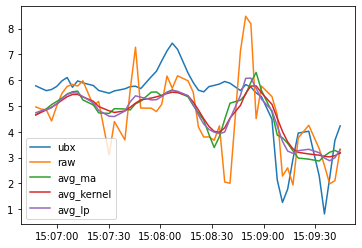

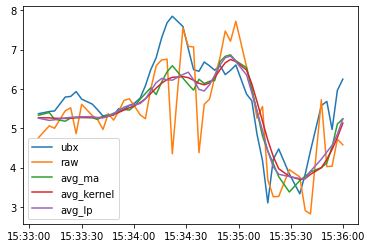

Avg velo RMSE: 			 1.345449683722063
Avg velo RMSE MA: 		 1.1018751108164628 	 ( -0.1810358097017597 )
Avg velo RMSE MA0: 		 1.11512625623919 	 ( -0.1711869498127232 )
Avg velo RMSE Kernel: 		 1.1443540231740388 	 ( -0.14946353102682486 )
Avg velo RMSE Kernel 0: 	 1.108134181677159 	 ( -0.1763837807656935 )
Avg velo RMSE LP: 		 1.0826082476735748 	 ( -0.19535582729586853 )
Avg velo RMSE LP0: 		 1.0536870061253012 	 ( -0.21685142233608257 )


In [14]:
raw_errors = []
ma_errors = []
ma0_errors = []
k_errors = []
k0_errors = []
lp_errors = []
lp0_errors = []

for exp in experiments: 
    raw_errors.append(mse(exp[2].velo, exp[2].velo_avg, squared=False))
    
    ma_w = int(ma_params)
    exp[2]['velo_ma_a2'] = exp[2].velo_a2.rolling(ma_w, center=True, min_periods = 1).mean()
    exp[2]['velo_ma_mi9'] = exp[2].velo_mi9.rolling(ma_w, center=True, min_periods = 1).mean()
    exp[2]['velo_ma_avg'] = exp[2].apply(lambda x: (x['velo_ma_mi9'] + x['velo_ma_a2'])/2, axis=1)        
    ma_errors.append(mse(exp[2].velo, exp[2].velo_ma_avg, squared=False))
    
    ma_w0 = int(ma_params0)
    exp[2]['velo_ma0_a2'] = np.where(exp[2].velo_a2.rolling(ma_w0, center=True, min_periods = 1).mean() < threshold, 0, exp[2].velo_a2.rolling(ma_w0, center=True, min_periods = 1).mean())
    exp[2]['velo_ma0_mi9'] = np.where(exp[2].velo_mi9.rolling(ma_w0, center=True, min_periods = 1).mean() < threshold, 0, exp[2].velo_mi9.rolling(ma_w0, center=True, min_periods = 1).mean())
    exp[2]['velo_ma0_avg'] = exp[2].apply(lambda x: (x['velo_ma0_mi9'] + x['velo_ma0_a2'])/2, axis=1)        
    ma0_errors.append(mse(exp[2].velo, exp[2].velo_ma0_avg, squared=False))    
    
    
    kernel_w = int(kernel_params[0])
    kernel_std = kernel_params[1]
    win_type = 'gaussian'
    exp[2]['velo_k_a2'] =  exp[2].velo_a2.rolling(window=kernel_w, win_type=win_type, center=True, min_periods = 1).mean(std=kernel_std)
    exp[2]['velo_k_mi9'] =  exp[2].velo_mi9.rolling(window=kernel_w, win_type=win_type, center=True, min_periods = 1).mean(std=kernel_std)
    exp[2]['velo_k_avg'] = exp[2].apply(lambda x: (x['velo_k_mi9'] + x['velo_k_a2'])/2, axis=1)        
    k_errors.append(mse(exp[2].velo, exp[2].velo_k_avg, squared=False))    
    
    kernel_w0 = int(kernel_params0[0])
    kernel_std0 = kernel_params0[1]
    win_type = 'gaussian'
    exp[2]['velo_k0_a2'] =  np.where(exp[2].velo_a2 < threshold, 0, exp[2].velo_a2.rolling(window=kernel_w0, win_type=win_type, center=True, min_periods = 1).mean(std=kernel_std0))
    exp[2]['velo_k0_mi9'] =  np.where(exp[2].velo_mi9 < threshold, 0, exp[2].velo_mi9.rolling(window=kernel_w0, win_type=win_type, center=True, min_periods = 1).mean(std=kernel_std0))
    exp[2]['velo_k0_avg'] = exp[2].apply(lambda x: (x['velo_k0_mi9'] + x['velo_k0_a2'])/2, axis=1)        
    k0_errors.append(mse(exp[2].velo, exp[2].velo_k0_avg, squared=False))
    
    
    lp_order = int(lp_params[0])
    lp_filter_value = lp_params[1]
    exp[2]['velo_lp_a2'] = low_pass(exp[2].velo_a2, lp_order, lp_filter_value)
    exp[2]['velo_lp_mi9'] = low_pass(exp[2].velo_mi9, lp_order, lp_filter_value)
    exp[2]['velo_lp_avg'] = exp[2].apply(lambda x: (x['velo_lp_mi9'] + x['velo_lp_a2'])/2, axis=1)        
    lp_errors.append(mse(exp[2].velo, exp[2].velo_lp_avg, squared=False))
    
    lp_order0 = int(lp_params0[0])
    lp_filter_value0 = lp_params0[1]
    exp[2]['velo_lp0_a2'] = np.where(exp[2].velo_a2 < threshold, 0, low_pass(exp[2].velo_a2, lp_order0, lp_filter_value0))
    exp[2]['velo_lp0_mi9'] = np.where(exp[2].velo_mi9 < threshold, 0, low_pass(exp[2].velo_mi9, lp_order0, lp_filter_value0))
    exp[2]['velo_lp0_avg'] = exp[2].apply(lambda x: (x['velo_lp0_mi9'] + x['velo_lp0_a2'])/2, axis=1)        
    lp0_errors.append(mse(exp[2].velo, exp[2].velo_lp0_avg, squared=False)) 

    f = 150
    t = 200
    
    plt.plot(exp[2].date_mi9[f:t], exp[2].velo[f:t], label='ubx')
    plt.plot(exp[2].date_mi9[f:t], exp[2].velo_avg[f:t], label='raw')
    plt.plot(exp[2].date_mi9[f:t], exp[2].velo_ma_avg[f:t], label='avg_ma')
    plt.plot(exp[2].date_mi9[f:t], exp[2].velo_k_avg[f:t], label='avg_kernel')
    plt.plot(exp[2].date_mi9[f:t], exp[2].velo_lp_avg[f:t], label='avg_lp')
    plt.legend()
    plt.show()
    
mean_raw_error = np.mean(raw_errors)
mean_ma_error = np.mean(ma_errors)
mean_ma0_error = np.mean(ma0_errors)
mean_k_error = np.mean(k_errors)
mean_k0_error = np.mean(k0_errors)
mean_lp_error = np.mean(lp_errors)
mean_lp0_error = np.mean(lp0_errors)

print('Avg velo RMSE: \t\t\t', mean_raw_error)
print('Avg velo RMSE MA: \t\t', mean_ma_error, '\t (', (mean_ma_error/mean_raw_error) - 1,')')
print('Avg velo RMSE MA0: \t\t', mean_ma0_error, '\t (', (mean_ma0_error/mean_raw_error) - 1, ')')
print('Avg velo RMSE Kernel: \t\t', mean_k_error, '\t (', (mean_k_error/mean_raw_error) - 1, ')')
print('Avg velo RMSE Kernel 0: \t', mean_k0_error, '\t (', (mean_k0_error/mean_raw_error) - 1, ')')
print('Avg velo RMSE LP: \t\t', mean_lp_error, '\t (', (mean_lp_error/mean_raw_error) - 1, ')')
print('Avg velo RMSE LP0: \t\t', mean_lp0_error, '\t (', (mean_lp0_error/mean_raw_error) - 1, ')')






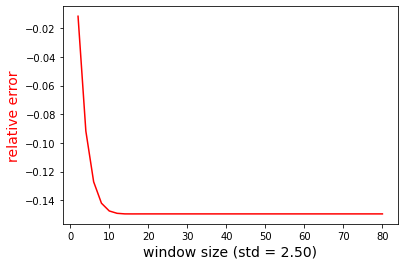

Text(0.5, 0, 'kernel std (window size = 16)')

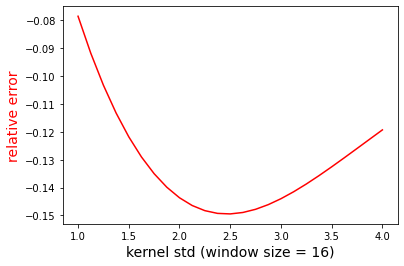

In [15]:
infos = []
for info in k_params_info:
    infos.append([info[0][0], info[0][1], info[1]])
    
df = pd.DataFrame(infos, columns=['w', 'std', 'val'])
df = df[df['std'] == kernel_params[1]]


plt.plot(df.w, (df.val/mean_raw_error) - 1, color='red')
plt.ylabel('relative error',color='red',fontsize=14)
plt.xlabel('window size (std = %.2f)'%kernel_params[1],fontsize=14)
plt.show()

df = pd.DataFrame(infos, columns=['w', 'std', 'val'])
df = df[df['w'] == kernel_params[0]]
plt.plot(df['std'], (df.val/mean_raw_error) - 1, color='red')
plt.ylabel('relative error',color='red',fontsize=14)
plt.xlabel('kernel std (window size = %i)'%kernel_params[0],fontsize=14)

Text(0, 0.5, 'error')

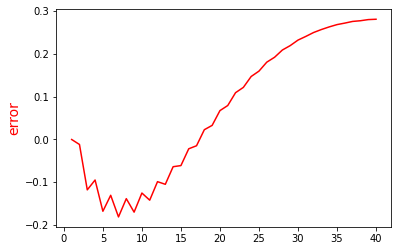

In [16]:
df = pd.DataFrame(ma_params_info, columns=['w', 'val'])

plt.plot(df.w, (df.val/mean_raw_error) - 1, color='red')

plt.ylabel('error',color='red',fontsize=14)



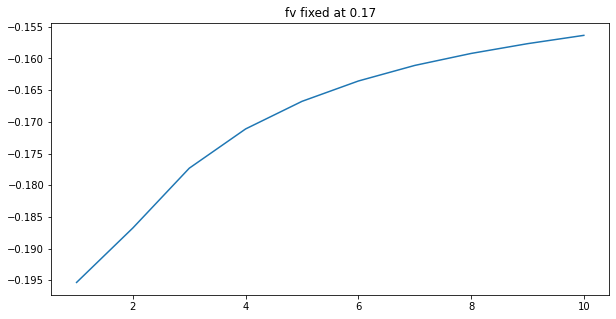

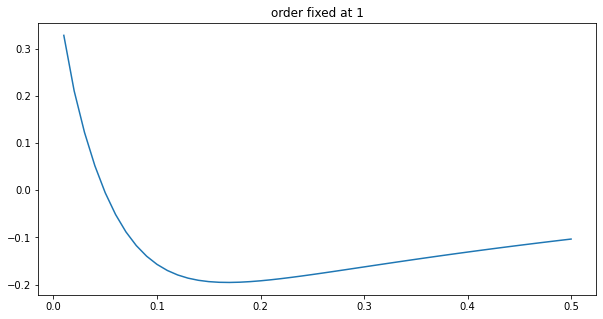

In [17]:
infos = []
for info in lp_params_info:
    infos.append([info[0][0], info[0][1], info[1]])

tmp = pd.DataFrame(infos, columns=['order', 'fv', 'val'])

plt.figure(figsize=(10,5))

plt.title('fv fixed at %.2f'%lp_params[1])
plt.plot(tmp[tmp['fv'] == lp_params[1]]['order'], tmp[tmp['fv'] == lp_params[1]]['val']/mean_raw_error - 1)
plt.show()
plt.figure(figsize=(10,5))
plt.title('order fixed at %i'%lp_params[0])
plt.plot(tmp[tmp['order'] == lp_params[0]]['fv'], tmp[tmp['order'] == lp_params[0]]['val'] /mean_raw_error - 1)
plt.show()